In [58]:
# Importing libraries
import sklearn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
import matplotlib as mpl
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score,cross_val_predict
from sklearn.base import clone, BaseEstimator
from sklearn.metrics import roc_auc_score,confusion_matrix,precision_score, recall_score,f1_score,precision_recall_curve,roc_curve


### Classification problem

In [4]:
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

### One line per instance and one column for each feature

In [5]:
X,y = mnist["data"],mnist["target"]
X.shape


### 70000 images with 784 features ( each image is 28x28 pixels )

(70000, 784)

In [6]:
y.shape

(70000,)

In [7]:
type(X)
X_numpy = X.to_numpy()

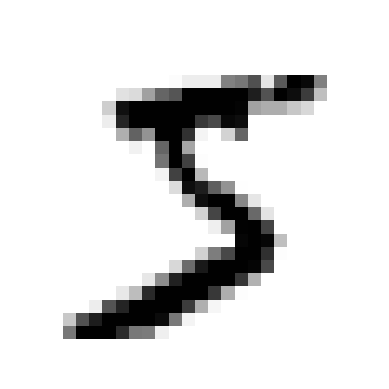

In [8]:
some_digit = X_numpy[0]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation="nearest")
plt.axis("off")

plt.show()

### Looks like a 5, let`s check

In [9]:
y[0]

# This is a string , i need to convert into numbers 

'5'

In [10]:
y = y.astype(np.uint8)

In [11]:
y[0]

5

### Separate the train and test set before anything

In [12]:
# The training set of MNIST is already shuffled. The test set are the last 10000 images
X_train, X_test, Y_train, Y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Binary Classifier

### I should identify the digit

### For example , trying to identify number 5 would have 2 classes : 5 and not 5 

In [13]:
y_train_5 = (Y_train == 5) # True when the label is 5
y_test_5 = (Y_test == 5)   # True when label is 5 

### Now training with SGD ( stochastic gradient descent) because it can deal better with large datasets

In [14]:
sgd_clf = SGDClassifier(random_state=42) 
sgd_clf.fit(X_train, y_train_5) # Using all my train dataset , i want to see which are 5

# In order to keep reproducible results ,i need to put random_state 

SGDClassifier(random_state=42)

In [15]:
sgd_clf.predict([some_digit])
# Should be true

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

# Performance Measures

## Cross-Validation

In [16]:
''' 

# Implementing cross-validation in order to have control over it 

skfolds = StratifiedKFold(n_splits = 3, random_state = 42)
# Splits equally in 3 (maintaing the ratio of the classes) and maintain the state to reproduce again

for train_index,test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf) # Clone the model

    # Track the values in train and test 
    # use a different index for train and test

    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_folds = X_test[test_index]
    y_test_folds = y_test_5[test_index]

    # I am using the model to evaluate the division made by stratifiedkfold
    # So i can test with EACH division and see the result


    clone_clf.fit(X_train_folds,y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct / len(y_pred))

''' 

' \n\n# Implementing cross-validation in order to have control over it \n\nskfolds = StratifiedKFold(n_splits = 3, random_state = 42)\n# Splits equally in 3 (maintaing the ratio of the classes) and maintain the state to reproduce again\n\nfor train_index,test_index in skfolds.split(X_train, y_train_5):\n    clone_clf = clone(sgd_clf) # Clone the model\n\n    # Track the values in train and test \n    # use a different index for train and test\n\n    X_train_folds = X_train[train_index]\n    y_train_folds = y_train_5[train_index]\n    X_test_folds = X_test[test_index]\n    y_test_folds = y_test_5[test_index]\n\n    # I am using the model to evaluate the division made by stratifiedkfold\n    # So i can test with EACH division and see the result\n\n\n    clone_clf.fit(X_train_folds,y_train_folds)\n    y_pred = clone_clf.predict(X_test_folds)\n    n_correct = sum(y_pred == y_test_folds)\n    print(n_correct / len(y_pred))\n\n'

In [17]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3 , scoring = 'accuracy')

array([0.95035, 0.96035, 0.9604 ])

### A high accuracy, testing with a dumb classifier

In [18]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X),1),dtype = bool)

### Classifies every image in not-5 class

In [19]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3 , scoring = 'accuracy')

array([0.91125, 0.90855, 0.90915])

### High accuracy. only 10% of the images should be 5

### This is the reason why accuracy is not always a good measure . Specially in skewed datasets (some classes way more frequent)

## Confusion Matrix

### Count the number of times that class A is classified as class B

### Thus , to look how many times the classifier confused image of 5 with 3 , i look row 5 , column 3 

In [20]:
# These predictions will be compared to the actual target
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

# Does not return the evaluation scores, but the prediction for each test fold

In [21]:
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

### what this means :

each row is the ACTUAL class   ( on this case the class used train_5)
each column is the PREDICTED class

First row -> Non 5 images
Second row -> 5 images

True Negatives False Positives 
False Negative True Positives

True and false when it got correct
Positive and false in accord of the class we are testing

In [22]:
y_train_perfect_predictions = y_train_5 # always see if it is 5 or not 
confusion_matrix(y_train_5,y_train_perfect_predictions)

# Only true Positives and true Negatives

array([[54579,     0],
       [    0,  5421]])

# I can look at the ACCURACY of the positive predictions. The precision of the classifier

Precision = TP/ TP + FP

from all positives (all classified as 5) , how many of them are really correctly classified?

does not matter how many are , just how many were indicated. so first i have to identify all the 5 and then i see how many i got right

This shows the trust in identifying my class

# Recall/ or sensitivity or True positive rate (TPR) helps with the info of accuracy

This is the ratio of positive instances that are correctly detected 

Recall = TP/ TP + FN

from all the 5 existents in the dataset , how many my model founded ? 

so if there were 100 images of 5 and my model only identified 10 , it has a recall of 10/100

it only gets how many number 5 were reached by the model !! 

this show the trust in finding , in my dataset, the class

In [23]:
precision_score(y_train_5,y_train_pred)

# Thus i have 83% of precision . From all the 5 that my model saw , it identified correctely 83%

0.8370879772350012

In [24]:
recall_score(y_train_5,y_train_pred)

# Hence i have 65% of recall . From all the 5 of my dataset ,my model only got 65% of them

0.6511713705958311

### Combining precision and recall in one metric is called F score
### It is the Harmonic mean of precision and recall because, while the 
### mean treats all numbers as equal, the harmonic gives more weight to lower values !!

### Thus , the F will have a high score only if both recall and precision are high

In [25]:
f1_score(y_train_5,y_train_pred)

0.7325171197343847

the f1 score favors classsifiers with SIMILAR precision and recall. 

But there are times i need more precision or recall. it is a tradeoff

In [26]:
# in order to set a threeshold i can use a decision function

In [27]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([2164.22030239])

In [28]:
threeshold = 0
y_some_digit_pred = (y_scores > threeshold)
y_some_digit_pred

array([ True])

In [29]:
threeshold = 8000
y_some_digit_pred = (y_scores> threeshold)
y_some_digit_pred

array([False])

raising the threeshold decreases recall

In [30]:
y_scores = cross_val_predict(sgd_clf,X_train , y_train_5 , cv=3 , method = 'decision_function')

### Now i can set the precision-recall curve to set my threeshold

In [31]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)


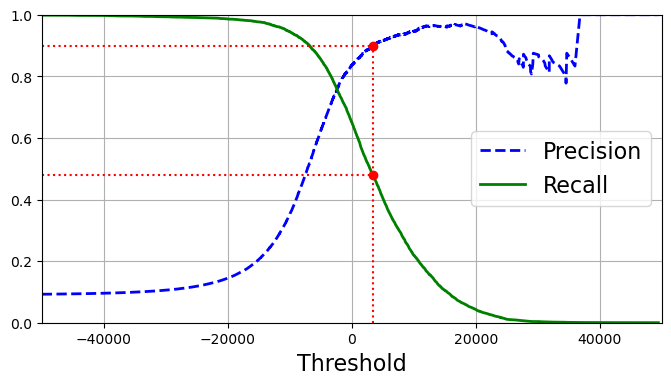

In [32]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
plt.show()

Notice how precision can go down if i increase the threshold

Another thing possible is to plot the precision x recall curve

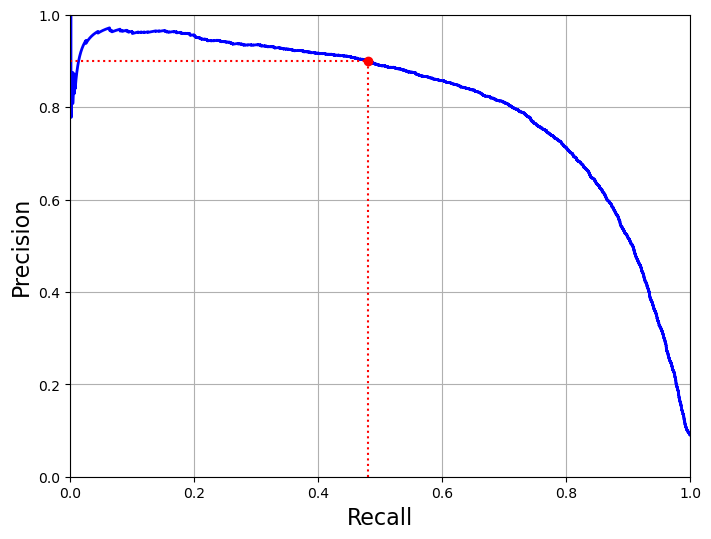

In [33]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

A high precision classifier is not useful if the recall is very low

# ROC CURVE

receiver operating characteristic (ROC) used in binary classifiers

Plots True Positive rate (recall) against False positive rate

FPR is the ratio of negative instances that are incorrectly classified as positive (1- TRUE NEGATIVE RATE) or specificity

So it is the plot sensitivity (recall) vs 1- specificity (TNR)

In [34]:
fpr, tpr, thresholds = roc_curve(y_train_5,y_scores)

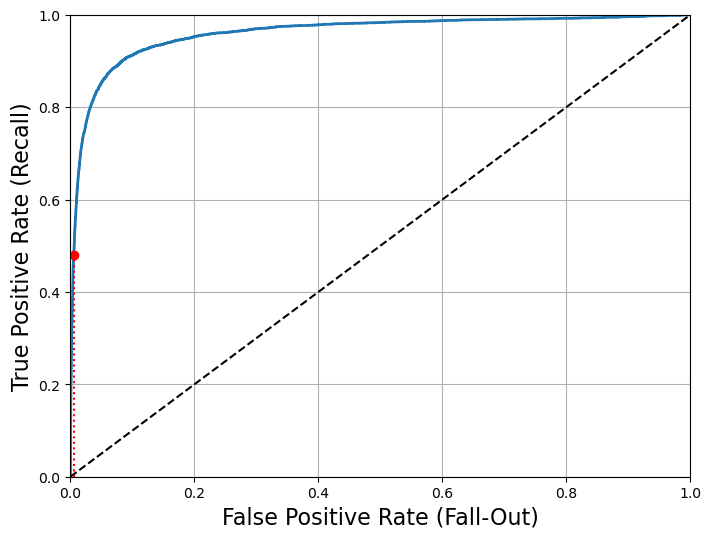

In [35]:
# I should plot False positive rate (recall) vs false positive rate

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
plt.show()

The classifier could improve , since the ROC curve shows that it could get a better recall and in an optimous position

on this position ,there are few positives (5) compared to negative (non 5) . so it doesn`t make so many mistakes (false positive) saying that some number is 5, when it is not . but from all the number 5, it does bring only half of the dataset

In [36]:
# Trying a new model: Random forest

forest_clf = RandomForestClassifier(random_state =42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method = 'predict_proba')

To use the ROC i need scores , not probabilities !!! 

So i will use the positive class probability

In [38]:
y_scores_forest = y_probas_forest[:,1] # prob of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

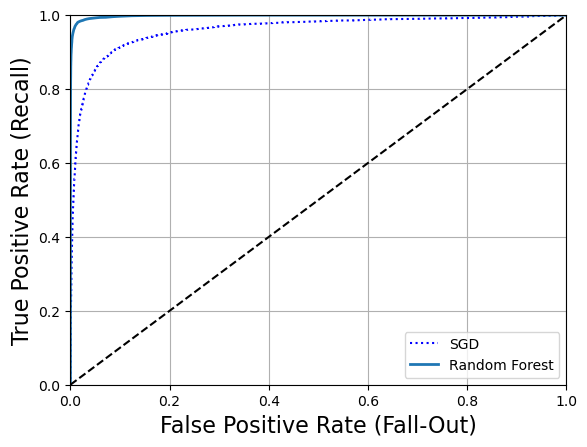

In [39]:
plt.plot(fpr,tpr,'b:', label="SGD")
plot_roc_curve(fpr_forest,tpr_forest, "Random Forest")
plt.legend(loc = "lower right")
plt.show()

In [46]:
# The curve of random forest looks much better because it is closer to the top left corner

roc_auc_score(y_train_5,y_scores_forest)

# it is closer to 1 , way better than the first model of SGD

0.9983296721818179

In [48]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9898819561551433

In [49]:
recall_score(y_train_5,y_train_pred_forest)

0.8662608374838591

### Thus , with a random forest, the model picks more of  the 5 of the dataset(recall) and can correctly identify them 98% of the times

# Multiclass Classification

One-versus-all(OvA) -> train 10 binary classifiers and then score them to see the best classifier

One-versus-one(OvO) -> binary classifiers like 0 and 1,  0 and 2, 1 and 3 ... so the combination of N picks 2 N * N-1 /2 

scikit learn detects if i try to use a binary classification for a multi class , and runs OvA

In [50]:
sgd_clf.fit(X_train,Y_train)
sgd_clf.predict([some_digit])


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([3], dtype=uint8)

actually scikit learn trained 10 binary classifiers and got the decision scores for the image, selecting the highest score

In [52]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [53]:
np.argmax(some_digit_scores)

3

In [55]:
forest_clf.fit(X_train,Y_train)
forest_clf.predict([some_digit])

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([5], dtype=uint8)

In [56]:
# what about the probabilities because it already classifies multiple classes
forest_clf.predict_proba([some_digit])

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([[0.  , 0.  , 0.02, 0.1 , 0.  , 0.86, 0.  , 0.  , 0.  , 0.02]])

Now , for evaluating the classifiers i should use Cross Validation

In [57]:
cross_val_score(sgd_clf, X_train,Y_train, cv=3 , scoring = 'accuracy')

array([0.87365, 0.85835, 0.8689 ])

Normalization of the Data : X_{scaled} = X - mean / standard deviation

In [60]:
scaler = StandardScaler()
X_train_scaler = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf , X_train_scaler, Y_train, cv=3 , scoring = 'accuracy')

array([0.8983, 0.891 , 0.9018])

# Error Analysis

In [61]:
# Time to analyse the types of errors that the models produces

y_train_pred = cross_val_predict(sgd_clf, X_train_scaler , Y_train , cv=3)

In [62]:
conf_mx = confusion_matrix(Y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

maybe it is better to represent with the matplotlib matshow function

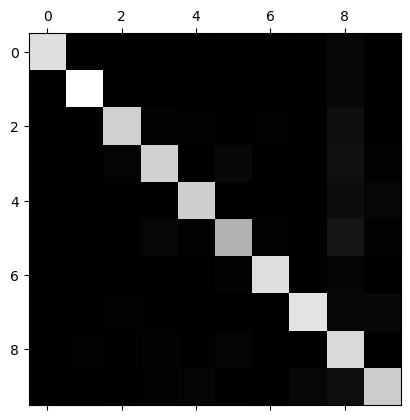

In [63]:
plt.matshow(conf_mx, cmap= plt.cm.gray)

Focus on the errors : 

Dividing each value of the confusion matrix by the number of images in the corresponding class to compare the error 

if i use aboslute errors , because some numbers appear more than others , some numbers could get way more errors than others


ex 

digit 1 : 1100 numbers , 20 errors
digit 7 : 300 numbers, 15 errors . 

using absolut error it looks like 7 is doing better than 1 
in reality we have 

20/1100 and 15/300 . Thus, digit 7 is worse than 1 


So ,for each TRUE CLASS i will divide the number of samples in that row so i can get
the percentage of the class

so ,for example ,
digit 5 can begin with

[0 , 5 , 10 ,27] and will turn into -> [0, 0.017, 0.35, 0.94]

In [64]:
row_sums = conf_mx.sum(axis =1, keepdims=True) # sum across columns
norm_conf_mx = conf_mx/row_sums

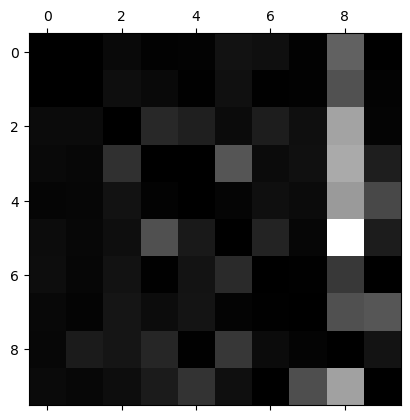

In [65]:
# Fill the diagonal with zeros to keep the errors 

np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

Finally i can see the type of the error that the classifier is doing

rows -> actual classes
columns -> predicted 

many images get a mistake classifying wrongly the number 8. specially the number 5 

i need to reduce the FALSE 8`s by getting more training data for digits that look like 8 (but are not) 

or get a function that counts the number of loops, or preprocess the images to make the close loops stands more

What happens is that using SGD, it is a linear classifier and treat each column(pixels) by some weight and since some numbers can look very close to each other like 5 and 3 ( as shown in the matrix), it is only differentiated by some columns (weights), getting a close output